# Gradient-based semantle solving agent

Defines an agent that uses a discrete version of gradient descent in embedding space to find the semantle target/secret word

In [1]:
from english_words import english_words_set
import matplotlib.pyplot as plt
import numpy as np
from semantle_simulator import SemantleSimulator

## Simulator for semantle

In [2]:
sem_sim = SemantleSimulator()

In [3]:
sem_sim.target = 'gather'

## Agent capabilities

Agent reuses semantle embedding space, but could potentially use a different semantic representation. Word list is closer (~30k) to what a human could potentially recall.

In [4]:
agent_semantics = sem_sim.wv
word_list = [w for w in list(english_words_set) if w in sem_sim.wv]
word_embeds = np.array([agent_semantics[w] for w in word_list])

## Similarity function and gradient representation

Measure the delta in embedding space from one word to another, and the associated delta in similarity to the target. Each guess adds to a discrete network of nodes (function value) and connecting spokes (function gradient in a specific direction)

In [5]:
def d_embed_location(i, j):
    return word_embeds[j] - word_embeds[i]

def d_target_similarity(i, j, node_similarities):
    si = node_similarities[i]
    sj = node_similarities[j]
    return sj - si

In [6]:
def register_guess(g, score, node_similarities, gradient_network):
    if g in node_similarities:
        print('duplicate guess')
        return
    node_similarities[g] = score
    spokes = []
    for j in gradient_network.keys():
        spoke_direction = d_embed_location(g, j)
        spoke_gradient = d_target_similarity(g, j, node_similarities)
        spokes.append((spoke_direction, spoke_gradient))
        gradient_network[j].append((-spoke_direction, -spoke_gradient))
    gradient_network[g] = spokes

## Make the next guess based on function/gradient

First seed a few random guesses.

In [7]:
def seed_guesses(node_sim, grad_net, n=3):
    for _ in range(n):
        g = np.random.randint(len(word_list))
        score = sem_sim.score_guess(word_list[g])
        register_guess(g, score, node_sim, grad_net)

Find the node with best similarity, move some random distance in the direction of steepest known gradient, and from that point find a close word not yet guessed. This could be more sophisticated but seems to work ok.

In [8]:
def get_top_node(node_sim):
    sorted_nodes = {k: v for k, v in sorted(node_sim.items(), key=lambda item: item[1])}
    return list(sorted_nodes.items())[-1]

def get_top_spoke(node, grad_net):
    sorted_spokes = [s for s in sorted(grad_net[node], key=lambda item: item[1])]
    return sorted_spokes[-1]

def semantic_leap(node, spoke, distance):
    return word_embeds[node] + spoke[0] * distance

def proximate_node(semantic_location, grad_net):
    proximities = agent_semantics.cosine_similarities(semantic_location, word_embeds)
    proximate_ids = np.argsort(proximities)
    j = 1
    while proximate_ids[-j] in grad_net:
        j = j + 1
    return proximate_ids[-j]     

def next_guess(node_sim, grad_net):
    node = get_top_node(node_sim)[0]
    spoke = get_top_spoke(node, grad_net)
    distance = np.random.rand(1) * 2
    semantic_location = semantic_leap(node, spoke, distance)
    return proximate_node(semantic_location, grad_net)

## Run the solving agent

In [9]:
node_similarities = {}
gradient_network = {}
seed_guesses(node_similarities, gradient_network)

guess_history = []
for k in node_similarities.keys():
    guess_history.append(k)

while get_top_node(node_similarities)[1] < 99:
    g = next_guess(node_similarities, gradient_network)
    score = sem_sim.score_guess(word_list[g])
    register_guess(g, score, node_similarities, gradient_network)
    guess_history.append(g)
    
len(node_similarities), word_list[g]

(55, 'gather')

## Visualise the results

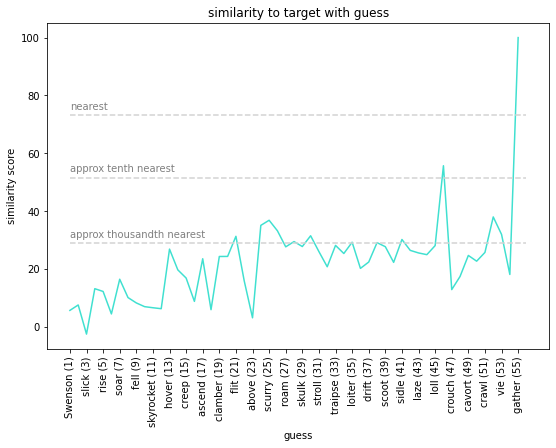

In [10]:
similarity_history = np.array([node_similarities[g] for g in guess_history])
tgt_cal = sem_sim.score_calibration()
plt.figure(figsize=(9, 6))
plt.plot(similarity_history, c='turquoise')
plt.plot([0, len(similarity_history)], [tgt_cal[0][1], tgt_cal[0][1]], '--', c='lightgrey')
plt.text(0, tgt_cal[0][1] + 2, 'nearest', c='grey') 
plt.plot([0, len(similarity_history)], [tgt_cal[1][1], tgt_cal[1][1]], '--', c='lightgrey')
plt.text(0, tgt_cal[1][1] + 2, 'approx tenth nearest', c='grey') 
plt.plot([0, len(similarity_history)], [tgt_cal[2][1], tgt_cal[2][1]], '--', c='lightgrey')
plt.text(0, tgt_cal[2][1] + 2, 'approx thousandth nearest', c='grey') 
plt.title('similarity to target with guess')
plt.ylabel('similarity score')
plt.xlabel('guess')
xtick_lim = 30
xtick_step = max(1, int(round(len(similarity_history) / xtick_lim)))
xticks = range(0, len(similarity_history), xtick_step)
xtick_labels = [f'{word_list[guess_history[xt]]} ({xt + 1})' for xt in xticks]
plt.xticks(xticks, xtick_labels, rotation=90)
plt.show()

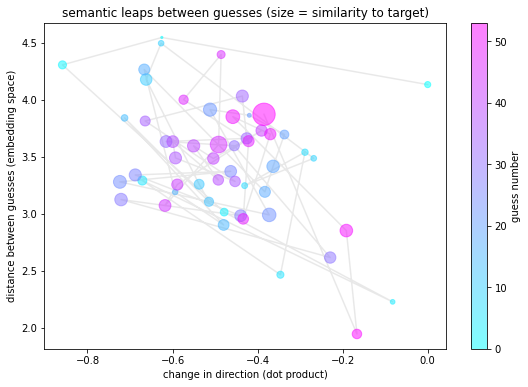

In [11]:
d_emb_loc = np.array([d_embed_location(g, h) for g, h in zip(guess_history[1:], guess_history[:-1])])
d_distance = np.array([np.linalg.norm(d) for d in d_emb_loc])
d_emb_norm = (d_emb_loc.T / d_distance.T).T
d_direction = [0] + [np.dot(d, e.T) for d, e in zip(d_emb_norm[1:], d_emb_norm[:-1])]
s_sim_hist = np.maximum(similarity_history[1:], 1.0)
plt.figure(figsize=(9, 6))
plt.scatter(d_direction, d_distance, s=(s_sim_hist * 5),
            c=range(len(guess_history) - 1), cmap='cool', zorder=1, alpha=0.5)
plt.plot(d_direction, d_distance, c='lightgrey', zorder=0, alpha=0.5)
plt.colorbar(label='guess number')
plt.title('semantic leaps between guesses (size = similarity to target)')
plt.xlabel('change in direction (dot product)')
plt.ylabel('distance between guesses (embedding space)')
plt.show()